# Power Plant Regression Analysis (With Outliers)

**Author**: Jian "Jim" He

## Project Overview
This project analyze power plant energy output using regression models with the following contents:
1. Outlier Detection and Removal using Cook's Distance
2. Compare model performance before and after outlier removal
3. Analyze the Reliability of Coefficients
4. Determine the Most Important vs Least Important Features
5. Visualize Regularization Paths

**Dataset**: Modified version of the Kaggle Power Plan dataset with artificial outliers.

**Target Variables**: Power Output (PE)

**Features**: Temperature (AT), Vacuum (V), Pressure (AP), Humidity (RH)



## Setup

In [24]:
# Import Library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# For regression models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

# Fixed RANDOM_STATE for Reproducibility
RANDOM_STATE = 42


## Utility Functions

In [25]:
def regression_metric(y_true, y_pred):
  """Return MAE, MSE, and R^2 as a dict """

  return {'MAE': mean_absolute_error(y_true, y_pred),
          'MSE': mean_squared_error(y_true, y_pred),
          'R^2': r2_score(y_true, y_pred)
  }


def evalute_model(model, X_train, X_test, y_train, y_test, model_name = None):
  """Fit regression model and return train/test metrics in a dictionary """

  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_metrics = regression_metric(y_train, y_train_pred)
  test_metrics = regression_metric(y_test, y_test_pred)

  output = {'Model': model_name,
            'Train MAE': train_metrics['MAE'],
            'Train MSE': train_metrics['MSE'],
            'Train R^2': train_metrics['R^2'],
            'Test MAE': test_metrics['MAE'],
            'Test MSE': test_metrics['MSE'],
            'Test R^2': test_metrics['R^2']
  }

  return output



## Load Dataset

Load dataset `usina_with_outliers.csv`

In [26]:
DATA_WITH_OUTLIERS_PATH = "usina_with_outliers.csv"
DATA_CLEAN_PATH = "usina.csv"

df_with_outliers = pd.read_csv(DATA_WITH_OUTLIERS_PATH)

print(df_with_outliers.shape)
display(df_with_outliers.head()) # first 5 lines of the csv



(9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


# 1. Outlier Detection and Removal using Cook's Distance (Statsmodels OLS)

## 1.1 Model choice and justification
We use the Ordinary Least Squares (OLS) Linear regression model and the Statsmodels library.

Why OLS Linear regression (vs Lasso/Ridge) for Cook's Distance?
- Cook's Distance is a influence diagnostics derived from the OLS framework (residuals + leverage from the hat matrix).
- Using OLS keep the influence interpretation standard and prevent the need to manually define "influence" under regularization.

Why Statsmodels (vs scikit-learn)?
- Statsmodels has built-in influence diagnostics through OLSInfluence, including Cook's Distance.
- This provide us a clean influence diagnostics following the standard statistical definition, whereas scikit-learn allow customized Cook's Distance calculation.


## 1.2 Identify outliers, remove them, and export clean `usina.csv`

We fit a OLS linear regression model and compute Cook's Distance for every single row.

We compute the Cook's Distance threshold using formula $D_i >  \frac{4}{n}$, where $n$ is the number of observation data (rows) and $ > \frac{4}{n}$ indicate it's an outlier.

Then, by removing flagged rows where, we will export the cleaned dataset.

In [27]:
# Features and Target
feature_cols = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df_with_outliers[feature_cols]
y = df_with_outliers[target_col]

# Fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)) # Statsmodels requires adding an intercept manually sm.add_constant(X)
ols_results = ols_model.fit()

# Calculate Cook's Distance
influence = OLSInfluence(ols_results)
cooks_distance = influence.cooks_distance[0] # array of the Cook's Distance value, one per row

# Outlier Threshold
n = len(df_with_outliers)
threshold = 4 / n

# Identify Outliers
is_outliers = cooks_distance > threshold
outliers = df_with_outliers[is_outliers]

# Create cleaned dataset
df_wo_outliers = df_with_outliers.loc[~is_outliers].copy()

# Export cleaned dataset csv
df_wo_outliers.to_csv(DATA_CLEAN_PATH, index=False)


### Visualized the indices of the outlier rows

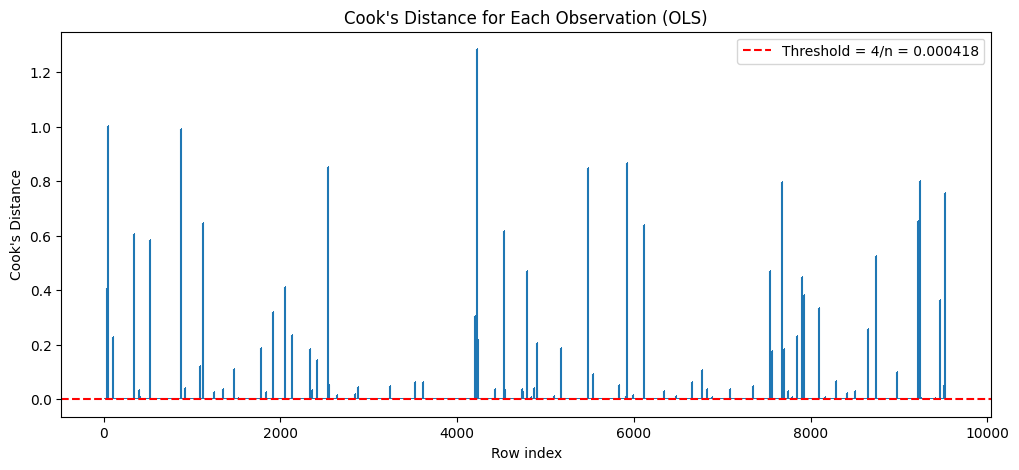

In [28]:
plt.figure(figsize=(12, 5))
plt.stem(np.arange(n), cooks_distance, markerfmt=",", basefmt=" ")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold = 4/n = {threshold:.6f}")
plt.title("Cook's Distance for Each Observation (OLS)")
plt.xlabel("Row index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# 2. Train/Test Evaluation Before vs After Outlier Removal

In this part, we will compare the model performance of `usina_with_outliers.csv` (original dataset) and `usina.csv` (cleaned dataset).

## Models
- OLS Linear Regression
- Ridge Regression with λ ∈ {0.01, 0.1, 1, 10, 100}
- Lasso Regression with λ ∈ {0.01, 0.1, 1, 10, 100}

## Train/Test Split
- Each dataset will have a 70/30 train/test split independently, with a unversal, fixed random state of 42 for reproducibility.

## Evaluation Metrics
- MAE
- MSE
- R²

Note: No scale of features or target has being used.


In [29]:
# Load datasets
df_with_outliers = pd.read_csv(DATA_WITH_OUTLIERS_PATH)
df_wo_outliers = pd.read_csv(DATA_CLEAN_PATH)

# Features and Target
feature_cols = ["AT", "V", "AP", "RH"]
target_col = "PE"

lambda_alpha = [0.01, 0.1, 1, 10, 100] # lambda is a reserved keyword in python, so we use lambda_alpha instead

#
def run_models(df_input, dataset_name):
  """
  - Split the dataset
  - Train each (Linear, Ridge, Lasso) models
  - Return a dataframe of evaluation metrics
  """

  # Features and target
  X = df_input[feature_cols]
  y = df_input[target_col]

  # Train/Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

  results = []

  # Linear Regression
  results.append(evalute_model(LinearRegression(), X_train, X_test, y_train, y_test, model_name = "Linear Regression"))

  # Ridge Regression
  for lam_alpha in lambda_alpha: # Try each lambda
    results.append(evalute_model(Ridge(alpha=lam_alpha, random_state=RANDOM_STATE), X_train, X_test, y_train, y_test, model_name = f"Ridge Regression (λ = {lam_alpha})"))

  # Lasso Regression
  for lam_alpha in lambda_alpha:
    results.append(evalute_model(Lasso(alpha=lam_alpha, max_iter=100000, random_state=RANDOM_STATE), X_train, X_test, y_train, y_test, model_name = f"Lasso Regression (λ = {lam_alpha})"))
    # Lasso is more sensitive to unscaled data; incrase max_iter for stability

  # Create result dataframe
  df_results = pd.DataFrame(results)

  print(f"\n======= Evaluation Metrics Results: {dataset_name} =======")
  display(df_results)

  return df_results

# Run for both datasets
df_with_outliers_results = run_models(df_with_outliers, "With Outliers")
df_wo_outliers_results = run_models(df_wo_outliers, "Without Outliers")



======= Evaluation Metrics Results: With Outliers =======


,Model,Train MAE,Train MSE,Train R^2,Test MAE,Test MSE,Test R^2
0,Linear Regression,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
1,Ridge Regression (λ = 0.01),5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
2,Ridge Regression (λ = 0.1),5.198680,123.384207,0.650171,5.052459,125.113392,0.642574
3,Ridge Regression (λ = 1),5.198685,123.384207,0.650171,5.052463,125.113421,0.642574
4,Ridge Regression (λ = 10),5.198737,123.384207,0.650171,5.052513,125.113705,0.642573
5,Ridge Regression (λ = 100),5.199261,123.384213,0.650171,5.053003,125.116548,0.642565
6,Lasso Regression (λ = 0.01),5.198858,123.384210,0.650171,5.052626,125.115332,0.642568
7,Lasso Regression (λ = 0.1),5.201739,123.384607,0.650169,5.055348,125.134495,0.642514
8,Lasso Regression (λ = 1),5.229507,123.421151,0.650066,5.083092,125.338356,0.641931
9,Lasso Regression (λ = 10),5.540418,126.141514,0.642353,5.408803,128.902136,0.631750



======= Evaluation Metrics Results: Without Outliers =======


,Model,Train MAE,Train MSE,Train R^2,Test MAE,Test MSE,Test R^2
0,Linear Regression,3.596396,19.864671,0.931369,3.624773,20.396772,0.930302
1,Ridge Regression (λ = 0.01),3.596396,19.864671,0.931369,3.624773,20.396772,0.930302
2,Ridge Regression (λ = 0.1),3.596397,19.864671,0.931369,3.624773,20.396770,0.930302
3,Ridge Regression (λ = 1),3.596400,19.864671,0.931369,3.624774,20.396750,0.930302
4,Ridge Regression (λ = 10),3.596430,19.864672,0.931369,3.624783,20.396549,0.930303
5,Ridge Regression (λ = 100),3.596742,19.864758,0.931369,3.624880,20.394626,0.930310
6,Lasso Regression (λ = 0.01),3.596368,19.864675,0.931369,3.624754,20.396738,0.930302
7,Lasso Regression (λ = 0.1),3.596855,19.865263,0.931367,3.624890,20.392600,0.930316
8,Lasso Regression (λ = 1),3.605523,19.929852,0.931144,3.631153,20.414755,0.930241
9,Lasso Regression (λ = 10),4.086632,25.685683,0.911258,4.120464,26.157253,0.910618


## Discussion

#### 1. Do outliers change train error? Test error?
- Yes, outliers significantly worsen the model's performance, supported by both train and test evaluation metrics.
- **With outliers (Linear Regression)** Train: MAE = 5.1987, MSE = 123.3842, R² = 0.6502; Test:  MAE = 5.0525, MSE = 125.1134, R² = 0.6426
- **Without ourliers (Linear Regression)** Train: MAE = 3.5964, MSE = 19.8647, R² = 0.9314; Test:  MAE = 3.6248, MSE = 20.3968, R² = 0.9303
- The dataset with outliers removed shows lower Test MAE (5.0525 -> 3.6248) and MSE (125.1134 -> 20.3968) while having a higher R² (0.6426 -> 0.9303).

#### 2. Which dataset (with outliers vs without outliers) shows better generalization?
- By comparing the train/test metrics and the gap in between, we found that the dataset without outliers shows a smaller gap ad thus a better generalization.
- **With outliers (Linear Regression)** Train MSE = 123.3842 va Test MSE = 125.1134, Gap = 1.7292
- **Without ourliers (Linear Regression)** Train MSE = 19.8647 vs Test MSE = 20.3968, Gap = 0.5321
- The cleaned dataset has a smaller train-test gap and much lower errors, indicating a more stable generalization.

#### 3. Do Ridge/Lasso appear to help relative to standard linear regression?
- Ridge Regression, in both datasets, performed almost identically with negligible differences. For example, in the with-outliers dataset, the Linear model has a test MSE of 125.113389 while the Ridge model of various λ has a test MSE around 125, if not worst, as λ increases.
- Lasso Regression, in both datasets, performed similar to Linear Regression when λ is small, but shows clear sign of underfitting as λ goes up. For example, with outliers, Lass (λ=10) has Test MSE = 128.9021 (worse than 125.1134 of Linear in the same with-outliers group), while Lasso (λ=100) has a Test MSE = 233.0643, much worse than λ=10 case; as for without-outliers group, Lasso (λ=10) has a Test MSE = 26.1573, and Lasso (λ=100) has a Test MSE = 132.1483, also much worse than the λ=10 case.

#### Summary
- The best model with outliers is the Linear / Ridge (λ=0.1) with the group's lowest MSE = 125.1134
- The best model without outliers is the Right (λ=100) with the group's lowest MSE = 20.3946

# 3. Reliability of Coefficients (For Outlier-Removed Dataset)

We will be using absolute t-value as our coefficient reliability.
- A most reliable coefficient = largest $|t|$
- A least reliable coefficient = smallest $|t|$

Our t-value is calculated through the standard formula $t = \frac{\hat{\beta}}{SE(\hat{\beta})}$.

## 3.1 Method choice and scaling decision
We use Ordinary Least Squares (OLS) Linear Regression model with Statsmodels library.
- **Why OLS?**  OLS provides built-in frameworks for statistical inference metrics in which coefficient reliability needs - Standard Error (SE), t-value, and Confidence Interval.
- **Why Statsmodels?** Statsmodels provides coefficient standard error (SE) and t-value directly through `.summary()`, `.params`, `.bse`, and `.tvalues` built-in functions.

We will not scale our independent variabels (IV) or dependent variables (DV) for this coefficient reliability task.
- **Why?** The t-value for a coefficient is computed as $t = \frac{\hat{\beta}}{SE(\hat{\beta})}$. If the IV is scaled or standardized to z-value, both its coefficient and the distribution's SE changed proportionally according to the scale, making the t-value essentially unchanged. Thus, scaling brings no benefits where it's redundant and thus unnecessary.

## 3.2 Implementation - Coefficient Reliability

We fit OLS Linear Regression model on `usina.csv`, extract its coefficients and t-values, then find out the most reliable (largest absolute t-value) and least reliable (smallest absolute t-value) coefficient.

In [30]:
# Load dataset
DATA_CLEAN_PATH = "usina.csv"
df_wo_outliers = pd.read_csv(DATA_CLEAN_PATH)

# Features and target
feature_cols = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df_wo_outliers[feature_cols]
y = df_wo_outliers[target_col]

# Fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X))
ols_results = ols_model.fit()

# Display regression summary
display(ols_results.summary())


# Create coefficient reliability dataframe table
df_coef_reliability = pd.DataFrame({
    "coefficient": ols_results.params,
    "std_error": ols_results.bse,
    "t_value": ols_results.tvalues,
    "abs_t_value": np.abs(ols_results.tvalues),
    "p_value": ols_results.pvalues
})

print("\n")
display(df_coef_reliability)


# We should get rid of the constant (intercept) row since we only compare the t-values for features.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:47:15   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.9993      9.743     45.265      0.000     421.902     460.097
AT            -1.9546      0.015   -129.113      0.000      -1.984      -1.925
V             -0.2379      0.007    -33.056      0.000      -0.252      -0.224
AP             0.0746      0.009      7.895      0.000       0.056       0.093
RH            -0.1489      0.004    -36.897      0.000      -0.157      -0.141
==============================================================================
Omnibus:                      107.740   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.435
Skew:                           0.007   Prob(JB):                     1.21e-41
Kurtosis:                       3.692   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,coefficient,std_error,t_value,abs_t_value,p_value
const,440.999323,9.742711,45.264539,45.264539,0.000000e+00
AT,-1.954640,0.015139,-129.113036,129.113036,0.000000e+00
V,-0.237885,0.007196,-33.056481,33.056481,7.527041e-227
AP,0.074638,0.009454,7.894540,7.894540,3.238569e-15
RH,-0.148856,0.004034,-36.897303,36.897303,1.578009e-278


## 3.2 Results - Most reliable vs least reliable coefficient (t-value evidence)

Based on our results table, excluding the const row containing the intercpets, we had:
- AT $|t| = 129.113036$
- V $|t| = 33.056482$
- AP $|t| = 7.894540$
- RH $|t| = 36.897303$

A larger $|t|$ means the coefficient is large relative to its uncertainty (standard error), so it is more reliably different from $0$.

Thus, the most reliable coefficient is AT for having the largest $|t| = 129.113036$, while the least relibale coefficient is AP for having the smallest $|t| = 7.894540$.




# 4. Most Important vs Least Important Features (Outlier-Removed Dataset)

## 4.1 Method choice and scaling decision
We will implement this part using Statsmodels OLS on the cleaned dataset `usina.csv`, and define feature importance as:
- Most important feature = largest absolute standardized coefficient
- Least important feature = smallest absolute standardized coefficient

To do this, standardization is reuqired because all the IV/features - AT, V, AP, RH - are measured in different units/scales, making the indigeneous data incomparable in magnitude. Thus, we will scale, or standardize, the the IV(s). After standardization all IV to z-score scale (mean = 0, SD = 1), each coefficient will represent the expected change in PE, or the target/DV, for a 1 standard deviation increase in that feature while holding others IVs fixed. Thus, the largest absolute standardized coefficient tells the most important feature.

To elaborate model and library choices, we use OLS Linear Regression model + Statsmodels OLS library with the same considerations stated earlier and to stay consistent. Plus, OLS coefficient provides a direct way to compare effect of features after scaling/standardization.


In [31]:
# Load dataset
DATA_CLEAN_PATH = "usina.csv"
df_wo_outliers = pd.read_csv(DATA_CLEAN_PATH)

# Feature and target
feature_cols = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df_wo_outliers[feature_cols].copy()
y = df_wo_outliers[target_col].copy()

# Standardize the features (IVs) to z-score
X_scaled = (X - X.mean()) / X.std()

# Fit the OLS on standardized features
ols_std_model = sm.OLS(y, sm.add_constant(X_scaled))
ols_std_results = ols_std_model.fit()

# Display regression summary
display(ols_results.summary())

# Create dataframe for importance
df_importance = pd.DataFrame({
    "standardized coefficient": ols_std_results.params,
    "abs_standardized_coefficient": np.abs(ols_std_results.params)
})

print("\n")
print("Feature Importance Table")
display(df_importance)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:47:15   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.9993      9.743     45.265      0.000     421.902     460.097
AT            -1.9546      0.015   -129.113      0.000      -1.984      -1.925
V             -0.2379      0.007    -33.056      0.000      -0.252      -0.224
AP             0.0746      0.009      7.895      0.000       0.056       0.093
RH            -0.1489      0.004    -36.897      0.000      -0.157      -0.141
==============================================================================
Omnibus:                      107.740   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.435
Skew:                           0.007   Prob(JB):                     1.21e-41
Kurtosis:                       3.692   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



Feature Importance Table


,standardized coefficient,abs_standardized_coefficient
const,454.299681,454.299681
AT,-14.557384,14.557384
V,-3.030898,3.030898
AP,0.442536,0.442536
RH,-2.197236,2.197236


## 4.2 Result Intrepretations

Based on the results table, excluding the const row that represents the intercepts, we can make the concluson that:
- Most important feature: AT $|\beta^*| = 14.557384$, highest.
- Least important feature: AP $|\beta^*| = 0.442536$, lowest.

# 5. Regularization Paths (Scaled Data, Outlier-Removed Dataset)

We will be starting with a wide log-scale range such as $λ ∈ [1e-4, 1e4]$ to ensure we capture the full regularization effect, then refine if needed.

We will scale the IVs, because both Ridge and Lasso Regression penalize the magnitude of coefficients, meaning that if features/IVs are in different units, the panelty might cause some features to shrink unfairly more than others. Standardizing, or scaling, the IVs ensures the regularization penalty is applied to all IVs fairly and that the coefficient paths are comparable.

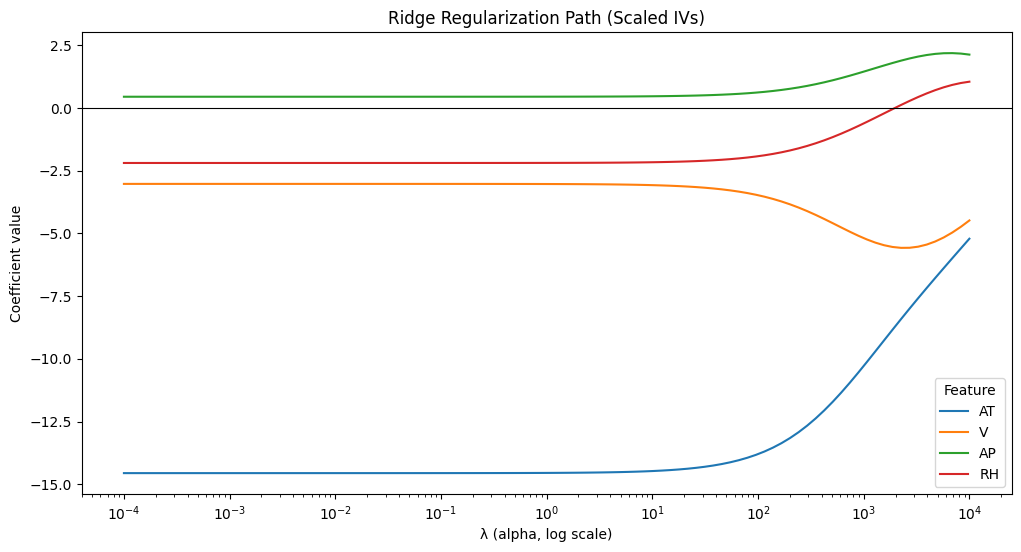

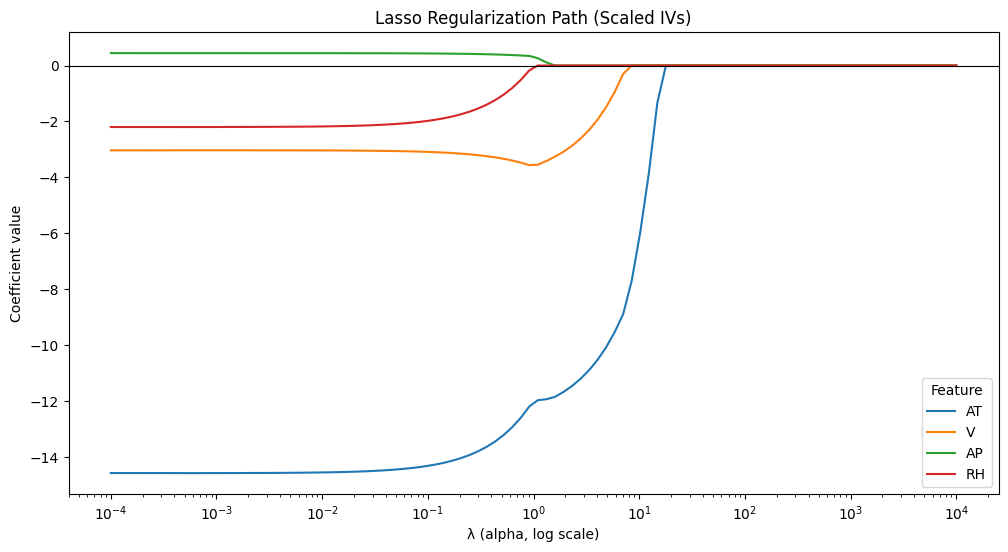

Ridge path preview (first 5 lambdas):


,AT,V,AP,RH,lambda
0,-14.556613,-3.030738,0.442513,-2.197120,0.000100
1,-14.556613,-3.030738,0.442513,-2.197120,0.000120
2,-14.556612,-3.030738,0.442513,-2.197120,0.000145
3,-14.556612,-3.030738,0.442513,-2.197120,0.000175
4,-14.556612,-3.030738,0.442513,-2.197119,0.000210




Lasso path preview (first 5 lambdas):


,AT,V,AP,RH,lambda
0,-14.557199,-3.030285,0.442311,-2.197173,0.000100
1,-14.557358,-3.030169,0.442261,-2.197197,0.000120
2,-14.557560,-3.030023,0.442199,-2.197229,0.000145
3,-14.557815,-3.029839,0.442120,-2.197271,0.000175
4,-14.558138,-3.029609,0.442023,-2.197328,0.000210


In [34]:
# Standard Scaler library
from sklearn.preprocessing import StandardScaler

# Load dataset
DATA_CLEAN_PATH = "usina.csv"
df_wo_outliers = pd.read_csv(DATA_CLEAN_PATH)

# Features and target
feature_cols = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df_wo_outliers[feature_cols].copy()
y = df_wo_outliers[target_col].copy()

# Standardize IVs to z-score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define lambda range
lambda_alpha = np.logspace(-4, 4, 100)

#
ridge_coef = []
lasso_coef = []

# Fit each model
for lam_alpha in lambda_alpha:
  ridge = Ridge(alpha=lam_alpha, random_state=RANDOM_STATE)
  ridge.fit(X_scaled, y)
  ridge_coef.append(ridge.coef_)

  lasso = Lasso(alpha=lam_alpha, max_iter=100000, random_state=RANDOM_STATE)
  lasso.fit(X_scaled, y)
  lasso_coef.append(lasso.coef_)


# Create result dataframe
df_ridge_path = pd.DataFrame(ridge_coef, columns=feature_cols)
df_ridge_path["lambda"] = lambda_alpha

df_lasso_path = pd.DataFrame(lasso_coef, columns=feature_cols)
df_lasso_path["lambda"] = lambda_alpha


# Plot

# Plot: Ridge coefficient paths
plt.figure(figsize=(12, 6))
for col in feature_cols:
    plt.plot(df_ridge_path["lambda"], df_ridge_path[col], label=col)

plt.xscale("log")
plt.title("Ridge Regularization Path (Scaled IVs)")
plt.xlabel("λ (alpha, log scale)")
plt.ylabel("Coefficient value")
plt.legend(title="Feature")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

# Plot: Lasso coefficient paths
plt.figure(figsize=(12, 6))
for col in feature_cols:
    plt.plot(df_lasso_path["lambda"], df_lasso_path[col], label=col)

plt.xscale("log")
plt.title("Lasso Regularization Path (Scaled IVs)")
plt.xlabel("λ (alpha, log scale)")
plt.ylabel("Coefficient value")
plt.legend(title="Feature")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

# show a preview of coefficient values at a few lambdas
print("Ridge path preview (first 5 lambdas):")
display(df_ridge_path.head())
print("\n")
print("Lasso path preview (first 5 lambdas):")
display(df_lasso_path.head())

## Discussion

#### 1. What happens to coefficients as λ increases in Ridge vs Lasso?
- In the Ridge Regression plot, all coefficients changes smoothly as λ increases, where they go toward 0 but don't just hit 0 excatly and goes flat.
- In the Lasso Regression plot, the coefficients shrink as λ increases, and multiple features eventually hit 0 (flat on the zero line).
- This “coefficients hitting exactly zero” behavior is the key difference between Lasso and Ridge model and is visible clearly in the plots.

#### 2. Which regression is better under multicollinearity in IVs, and why?
- Ridge Regression is typicallky better under multicollinearity (correlated features/IVs), because it shrinks correlated coefficients continuously and keep the correlated predictors in the model together. It also helps to stabilizes the estimates by reducing variance without forcing coefficients to zeros (feature removal)abruptly.
- This statement is consistent with our result plot, where the coefficient curve in Ridge Regression is smoothier and none of them are forced to 0 even at high λ, unlike the Lasso Regression plot.

#### 3. Which regression is better for feature selection, and why?
- Lasso Regression is better for feature selection, because it can drive the coefficients to exactly 0, and since features with coefficient equals to 0 is effevtively removed from the model, the Lasso Regression will eventually produce a sparse model.
- This is supported by our output curve of the Lasso Regression, where our features/IVs - AP, RH, V, and eventually AT - became exactly 0 as λ goes up, indicating that Lasso model is selecting a smaller subset of features of higher regularization strengths.

